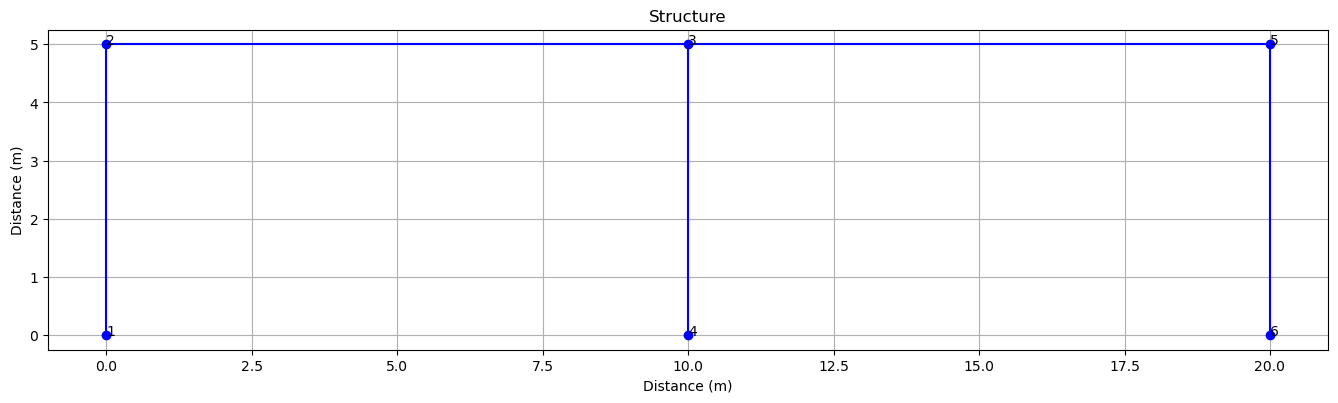

C:\Users\Msi\AppData\Local\Temp\ipykernel_16024\3836988917.py:314: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UG[i] = U[c]


In [1]:
# DEPENDENCIES
import copy 
import math # For math functionality
import numpy as np #NumPy for arrays
import matplotlib.pyplot as plt # For plotting functionality
import matplotlib.patches as patch #BMD and SFD

#========================================START OF DATA ENTRY========================================
#Constants
E = 200*10**9 #(N/m^2)
A = 0.03 #(m^2)
I = 300*10**-6 #(m^4)
import numpy as np
xFac = 20 #Scale factor for displacements plot

#Nodal cooridnates [x,y] (in ascending node order)
nodes = np.array([[0,0],
                  [0,5],
                  [10,5],
                  [10,0],
                  [20,5],
                  [20,0],])

#Members [node_i , node_j]
members = np.array([
                   [1,2], #M-0
                   [2,3],
                   [3,4],
                   [3,5],
                   [5,6],]) 
#pin flags [node_i , node_j]
#pins = np.ones([len(members),2])


#Supports (User Defined)
restrainedDoF = [1,2,3,10,11,12,16,17,18] #supports DoF restrained

#Loadings
forceVector = np.array([np.zeros(len(nodes)*3)]).T #External Forces Vector
forceVector[3]= 200000

#Distributed Loadings perpendicular to members
ENForces = np.zeros(members.shape) #Nodal Forces Container 
ENMoments = np.zeros(members.shape) #Nodal Moments Container

w1 = 10000 #N/m
w2 = 20000
l= 5 #meters
FValue1 = -w1*l/2
MValue1 = w1*l**2/12
FValue2 = -w2*l/2
MValue2 = w2*l**2/12

#force_values = np.tile([FValue, FValue])
#moment_values = np.tile([MValue, -MValue])

# Assign to slices
ENForces[1,:] = np.array([FValue1, FValue1])
ENMoments[1,:] = np.array([MValue1, -MValue1])

ENForces[3,:] = np.array([FValue2, FValue2])
ENMoments[3,:] = np.array([MValue2, -MValue2])

#========================================END OF DATA ENTRY=========================================

import matplotlib.pyplot as plt # For plotting functionality

dx=0.001
dy=0.001
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot Members
for mbr in members:
    node_i = mbr[0] #Member node_i (number)
    node_j = mbr[1] #Member node_j (number)
    
    ix = nodes[node_i-1,0] #x coordinate of node_i of the member
    iy = nodes[node_i-1,1] #y coordinate of node_j of the member
    jx = nodes[node_j-1,0] #x coordinate of node_j of the member
    jy = nodes[node_j-1,1] #y coordinate of node_j of the member

    #note: default numbering in python index are (0,1,2,.....), pag sa integer (1,2,3,......)
    ia = 3*node_i-3 #index 0 
    ib = 3*node_i-1 #index 2
    ja = 3*node_j-3 #index 3
    jb = 3*node_j-1 #index 5 

    axes.plot([ix,jx],[iy,jy],'b') #Member

#Plot nodes
for n, node in enumerate(nodes):
    axes.plot([node[0]],[node[1]],'bo')

    label = str(n+1)
    plt.text(node[0]+dx, node[1]+dy, label, fontsize = 10)

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure')
axes.grid()
plt.show()

def memberOrientation(memberNo):
    memberIndex = memberNo-1
    node_i = members[memberIndex][0] #Node number for node i
    node_j = members[memberIndex][1] #Node number for node j

    xi = nodes[node_i-1][0] #x coordinate for node i
    yi = nodes[node_i-1][1] #y coordinate for node i
    xj = nodes[node_j-1][0] #x coordinate for node j
    yj = nodes[node_j-1][1] #y coordinate for node j

    #Angle of member with respect to horizontal axis (Global)
    
    dx = xj-xi #vector x component
    dy = yj-yi #vector y component
    mag = math.sqrt(dx**2 + dy**2) #Vector magnitude
    memberVector = np.array([dx,dy]) #Member as Vector

    #Appropriate reference axis and offset angle
    if (dx>0 and dy==0):
        theta = 0
    elif(dx==0 and dy>0):
        theta = math.pi/2
    elif(dx<0 and dy==0):
        theta = math.pi
    elif(dx==0 and dy<0):
        theta = 3*math.pi/2
    elif(dx>0 and dy>0):
        # 0 < theta <90
        refVector = np.array([1,0]) #Positive x-axis
        theta = math.acos(refVector.dot(memberVector)/(mag)) #Formula for angle between 2 vectors "(math.acos(refVector.dot(memberVector)/(mag)))"
    elif(dx<0 and dy>0):
        # 90 < theta <180
        refVector = np.array([0,1]) #Positive y-axis
        theta = (math.pi/2) + math.acos(refVector.dot(memberVector)/(mag)) 
    elif(dx<0 and dy<0):
        # 180 < theta < 270
        refVector = np.array([-1,0]) #Negative x-axis
        theta = math.pi + math.acos(refVector.dot(memberVector)/(mag))
    else:
        # 270 < theta < 360
        refVector = np.array([0,-1]) #Negative y-axis
        theta = (3*math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))

    return [theta,mag]

import math # For math functionality
#Member Calculation of orientation and lengths (Store)
orientations = np.array([]) #array for orientations
lengths = np.array([]) #array for lengths
for n, mbr in enumerate(members):
    [angle, length] = memberOrientation(n+1)
    orientations = np.append(orientations,angle)
    lengths = np.append(lengths,length)
    
#Combine ENA with Original Nodal Actions to get Final Nodal Actions
for n,mbr in enumerate(members):
    node_i = mbr[0]
    node_j = mbr[1]

    fyi = ENForces[n,0]
    mi = ENMoments[n,0]
    fyj = ENForces[n,1]
    mj = ENMoments[n,1]
    
    # Transformation Matrix (TM)
    theta = orientations[n]
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0,0,0],
                   [-s,c,0,0,0,0],
                   [0,0,1,0,0,0],
                   [0,0,0,c,s,0],
                   [0,0,0,-s,c,0],
                   [0,0,0,0,0,1]])

    ENA_local = np.array([[0,fyi,mi,0,fyj,mj]]).T 
    ENA_global = np.matmul(T.T,ENA_local) #Global Coordinates
    ia = 3*node_i-3
    ja = 3*node_j-3

    #Update force vector
    forceVector[ia] = forceVector[ia] + ENA_global[0,0]
    forceVector[ia+1] = forceVector[ia+1] + ENA_global[1,0]
    forceVector[ia+2] = forceVector[ia+2] + ENA_global[2,0]

    forceVector[ja] = forceVector[ja] + ENA_global[3,0]
    forceVector[ja+1] = forceVector[ja+1] + ENA_global[4,0]
    forceVector[ja+2] = forceVector[ja+2] + ENA_global[5,0]

def calculateKg(memberNo):
    theta = orientations[memberNo-1]
    L = lengths[memberNo-1]
    c = math.cos(theta)
    s = math.sin(theta)
    # Transformation Matrix (TM)
    TM = np.array([[c,s,0,0,0,0],
                   [-s,c,0,0,0,0],
                   [0,0,1,0,0,0],
                   [0,0,0,c,s,0],
                   [0,0,0,-s,c,0],
                   [0,0,0,0,0,1]])

    #Local Stiffness Matrix of Individual Elements
    #Row 1
    k11 = E*A/L
    k12 = 0
    k13 = 0
    k14 = -E*A/L
    k15 = 0
    k16 = 0
    #Row 2
    k21 = 0
    k22 = 12*E*I/L**3
    k23 = -6*E*I/L**2
    k24 = 0
    k25 = -12*E*I/L**3
    k26 = -6*E*I/L**2
    #Row 3
    k31 = 0
    k32 = -6*E*I/L**2
    k33 = 4*E*I/L
    k34 = 0
    k35 = 6*E*I/L**2
    k36 = 2*E*I/L
    #Row 4
    k41 = -E*A/L
    k42 = 0
    k43 = 0
    k44 = E*A/L
    k45 = 0
    k46 = 0
    #Row 5 
    k51 = 0
    k52 = -12*E*I/L**3
    k53 = 6*E*I/L**2
    k54 = 0
    k55 = 12*E*I/L**3
    k56 = 6*E*I/L**2
    #Row 6
    k61 = 0
    k62 = -6*E*I/L**2
    k63 = 2*E*I/L
    k64 = 0
    k65 = 6*E*I/L**2
    k66 = 4*E*I/L
    
    #Quadrants of Local stiffness matrix
    K11 = np.array([[k11,k12,k13],[k21,k22,k23],[k31,k32,k33]])
    K12 = np.array([[k14,k15,k16],[k24,k25,k26],[k34,k35,k36]])
    K21 = np.array([[k41,k42,k43],[k51,k52,k53],[k61,k62,k63]])
    K22 = np.array([[k44,k45,k46],[k54,k55,k56],[k64,k65,k66]])
    
    #Complete local Element Stiffness Matrix
    top = np.concatenate((K11,K12),axis=1) #Top 3 rows
    btm = np.concatenate((K21,K22),axis=1) #Bottom 3 rows
    Kl = np.concatenate((top,btm),axis=0) #Complete

    #Global Stiffness Matrix
    Kg = np.round(TM.T@Kl@TM,1)

    #Divide global stiffness matrix for return
    K11g = Kg[0:3,0:3]
    K12g = Kg[0:3,3:6]
    K21g = Kg[3:6,0:3]
    K22g = Kg[3:6,3:6]

    return [K11g, K12g, K21g, K22g]
#Primary Stiffness Matrix
nDoF = np.amax(members)*3
Kp = np.zeros([nDoF, nDoF])

for n, mbr in enumerate(members):
    [K11,K12,K21,K22] = calculateKg(n+1)
    node_i = mbr[0]
    node_j = mbr[1]

    #note: default numbering in python index are (0,1,2,.....), pag sa integer (1,2,3,......)
    #Node i as node 1 & Node j as node 2 for each members
    ia = 3*node_i-3 #index 0 
    ib = 3*node_i-1 #index 2
    ja = 3*node_j-3 #index 3
    jb = 3*node_j-1 #index 5 

    Kp[ia:ib+1,ia:ib+1] = Kp[ia:ib+1,ia:ib+1] + K11
    Kp[ia:ib+1,ja:jb+1] = Kp[ia:ib+1,ja:jb+1] + K12
    Kp[ja:jb+1,ia:ib+1] = Kp[ja:jb+1,ia:ib+1] + K21
    Kp[ja:jb+1,ja:jb+1] = Kp[ja:jb+1,ja:jb+1] + K22

restrainedIndex = [x-1 for x in restrainedDoF] 

#Reduced structure stiffness matrix
Ks = np.delete(Kp,restrainedIndex,0) #Para ma delete rows ng matrix para sa support
Ks = np.delete(Ks,restrainedIndex,1) #Para ma delete column
Ks = np.matrix(Ks) # Array to Matrix

import copy 
forceVectorRed = copy.copy(forceVector)
forceVectorRed = np.delete(forceVectorRed,restrainedIndex,0) # Delete rows corresponding to restrained DoF (Supports)
U = Ks.I*forceVectorRed

# Reactions
UG = np.zeros(nDoF)
c = 0;
for i in np.arange(nDoF):
    if i in restrainedIndex:
        #Impose Zero Displacement
        UG[i] = 0
    else:
        #Assign Actual Displacement
        UG[i] = U[c]
        c=c+1

UG = np.array([UG]).T
FG = np.matmul(Kp,UG)


### Solve for Reactions

In [2]:
UG = np.zeros(nDoF)
c = 0;
for i in np.arange(nDoF):
    if i in restrainedIndex:
        #zero Displacement
        UG[i] = 0 
    else:
        #Displacement Value
        UG[i] = U[c]
        c=c+1

UG = np.array([UG]).T
FG = np.matmul(Kp,UG)



C:\Users\Msi\AppData\Local\Temp\ipykernel_16024\964273536.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UG[i] = U[c]


### Member Actions

In [3]:
mbrForces = np.array([])
mbrShears = np.zeros(members.shape)
mbrMoments = np.zeros(members.shape)

for n,mbr in enumerate(members):
    theta = orientations[n]
    L = lengths[n]

    node_i = mbr[0]
    node_j = mbr[1]

    ia = 3*node_i-3 #index 0 
    ib = 3*node_i-1 #index 2
    ja = 3*node_j-3 #index 3
    jb = 3*node_j-1 #index 5 

    c = math.cos(theta)
    s = math.sin(theta)

    #Transformation Matrix
    T= np.array([[c,s,0,0,0,0],
                   [-s,c,0,0,0,0],
                   [0,0,1,0,0,0],
                   [0,0,0,c,s,0],
                   [0,0,0,-s,c,0],
                   [0,0,0,0,0,1]])
    disp = np.array([[UG[ia,0],UG[ia+1,0],UG[ib,0],UG[ja,0],UG[ja+1,0],UG[jb,0]]]).T
    disp_local= np.matmul(T,disp)

    F_axial = (A*E/L)*(disp_local[3]-disp_local[0])[0]

    [K11,K12,K21,K22] = calculateKg(n+1)
    top = np.concatenate((K11,K12),axis=1)
    btm = np.concatenate((K21,K22),axis=1)
    Kg = np.concatenate((top,btm),axis=0)

    Kl = T.dot(Kg).dot(T.T)

    #End Moments
    Mi = Kl[2,:].dot(disp_local)[0]
    Mj = Kl[5,:].dot(disp_local)[0]

    #Shear Forces
    Fy_i = Kl[1,:].dot(disp_local)[0]
    Fy_j = Kl[4,:].dot(disp_local)[0]

    #Store
    mbrForces = np.append(mbrForces,F_axial)
    mbrShears[n,0] = Fy_i
    mbrShears[n,1] = Fy_j
    mbrMoments[n,0] = Mi
    mbrMoments[n,1] = Mj

In [4]:
# Remove the influence of equivalent nodal actions 
for n,mbr in enumerate(members):
    node_i = mbr[0]
    node_j = mbr[1]

    fyi = ENForces[n,0]
    mi = ENMoments[n,0]
    fyj = ENForces[n,1]
    mj = ENMoments[n,1]
    
    # Transformation Matrix (TM)
    theta = orientations[n]
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0,0,0],
                   [-s,c,0,0,0,0],
                   [0,0,1,0,0,0],
                   [0,0,0,c,s,0],
                   [0,0,0,-s,c,0],
                   [0,0,0,0,0,1]])

    ENA_local = np.array([[0,fyi,mi,0,fyj,mj]]).T 
    ENA_global = np.matmul(T.T,ENA_local) #Global Coordinates
    ia = 3*node_i-3
    ja = 3*node_j-3

    FG[ia] = FG[ia] - ENA_global[0,0]
    FG[ia+1] = FG[ia+1] - ENA_global[1,0]
    FG[ia+2] = FG[ia+2] - ENA_global[2,0]

    FG[ja] = FG[ja] - ENA_global[3,0]
    FG[ja+1] = FG[ja+1] - ENA_global[4,0]
    FG[ja+2] = FG[ja+2] - ENA_global[5,0]


In [5]:
# Removing ENA from member actions
# Remove the influence of equivalent nodal actions 
for n,mbr in enumerate(members):
    
    #calculated member actions
    Fy_i = mbrShears[n,0]
    Fy_j = mbrShears[n,1]
    Mi = mbrMoments[n,0]
    Mj = mbrMoments[n,1]

    fyi = ENForces[n,0]
    mi = ENMoments[n,0]
    fyj = ENForces[n,1]
    mj = ENMoments[n,1]
    
    # Transformation Matrix (TM)
    theta = orientations[n]
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0,0,0],
                   [-s,c,0,0,0,0],
                   [0,0,1,0,0,0],
                   [0,0,0,c,s,0],
                   [0,0,0,-s,c,0],
                   [0,0,0,0,0,1]])

    ENA_local = np.array([[0,fyi,mi,0,fyj,mj]]).T 
    ENA_global = np.matmul(T.T,ENA_local) #Global Coordinates

    calActions_local = np.array([[0,Fy_i,Mi,0,Fy_j,Mj]]).T
    calActions_global = np.matmul(T.T,calActions_local)

    finalActionsLocal = np.matmul(T,calActions_global-ENA_global)

    #Update members actions after removing influence of ENA
    mbrShears[n,0] = finalActionsLocal[1,0]
    mbrShears[n,1] = finalActionsLocal[4,0]
    mbrMoments[n,0] = finalActionsLocal[2,0]
    mbrMoments[n,1] = finalActionsLocal[5,0]

### Plotting

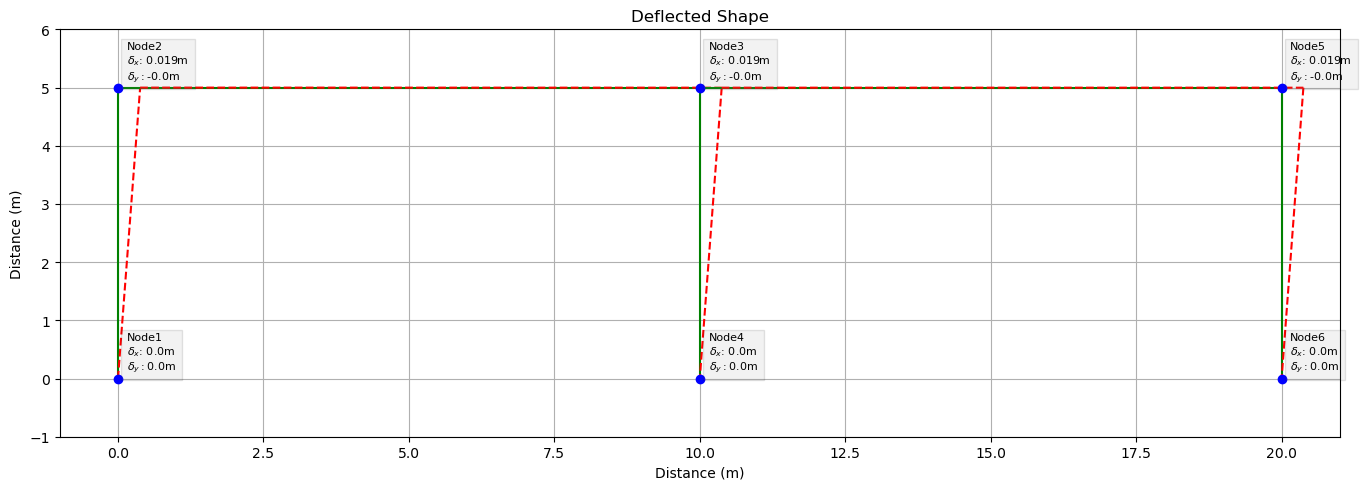


NODAL DISPLACEMENTS
Node 1: Ux = 0.0 m, Uy = 0.0 m, theta = 0.0 radians
Node 2: Ux = 0.019067 m, Uy = -3e-06 m, theta = 0.003735 radians
Node 3: Ux = 0.018827 m, Uy = -6.5e-05 m, theta = 0.002227 radians
Node 4: Ux = 0.0 m, Uy = 0.0 m, theta = 0.0 radians
Node 5: Ux = 0.018714 m, Uy = -5.7e-05 m, theta = 0.002793 radians
Node 6: Ux = 0.0 m, Uy = 0.0 m, theta = 0.0 radians


In [6]:
fontSize = 8 
margin = 1
dx = 0.15 #x-offset for node label
dy = 0.15 #y-offset for node label

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

for n, mbr in enumerate(members):
    node_i = mbr[0] 
    node_j = mbr[1]
    
    ix = nodes[node_i-1,0] #x coordinate of node_i of the member
    iy = nodes[node_i-1,1] #y coordinate of node_j of the member
    jx = nodes[node_j-1,0] #x coordinate of node_j of the member
    jy = nodes[node_j-1,1] #y coordinate of node_j of the member
    
    #note: default numbering in python index are (0,1,2,.....), pag sa integer (1,2,3,......)
    ia = 3*node_i-3 #index 0 
    ib = 3*node_i-1 #index 2
    ja = 3*node_j-3 #index 3
    jb = 3*node_j-1 #index 5

    axes.plot([ix,jx],[iy,jy],'g')
    axes.plot([ix + UG[ia,0]*xFac, jx + UG[ja,0]*xFac], [iy + UG[ia+1,0]*xFac, jy + UG[ja+1,0]*xFac],'--r') #Deformation

#Plot Nodes
for n, node in enumerate(nodes):
    axes.plot([node[0]],[node[1]],'bo')
    
    ia = 3*(n+1)-3 #Horizontal DoF
    ib = ia+1 #Vertical DoF
    
    delX = str(round(UG[ia,0],3)) #x displacement
    delY = str(round(UG[ib,0],3)) #y displacement
    label = "Node" + str(n+1) + "\n$\delta_x$: " + delX + "m \n$\delta_y:$" + delY + 'm'
    plt.text(node[0]+dx, node[1]+dy, label, fontsize = fontSize, bbox = dict(facecolor ='grey', alpha=0.1) )

#Axis Limits
maxX = nodes.max(0)[0]
maxY = nodes.max(0)[1]
minX = nodes.min(0)[0]
minY = nodes.min(0)[1]
axes.set_xlim([minX-margin, maxX + margin])
axes.set_ylim([minY-margin, maxY + margin])

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected Shape')
axes.grid()
plt.show()

print("")
print("NODAL DISPLACEMENTS")
for n, node in enumerate(nodes):
    ix = 3*(n+1)-3 #Horizontal DoF
    iy = ix+1 #Vertical DoF
    iz = ix+2 #Rotational DoF
    ux = round(UG[ix,0],6)
    uy = round(UG[iy,0],6)
    theta = round(UG[iz,0],6)
    print('Node {one}: Ux = {two} m, Uy = {three} m, theta = {four} radians'.format(one=n+1, two=ux, three=uy, four=theta))

### Axial Forces

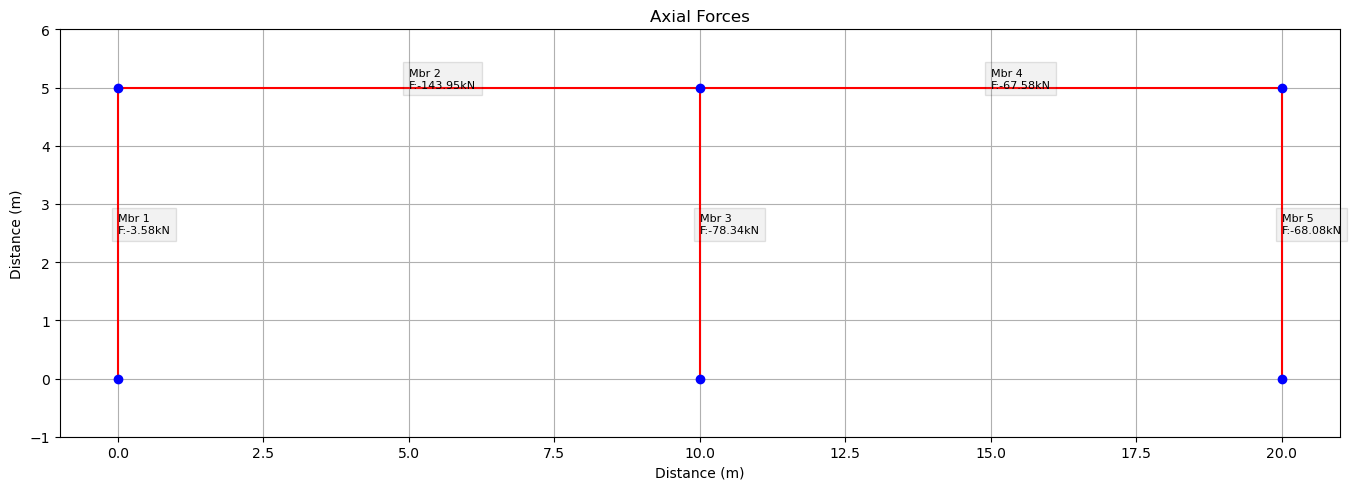

In [7]:
import matplotlib.pyplot as plt

fontSize = 8 
margin = 1
dx = 0.15 #x-offset for node label
dy = 0.15 #y-offset for node label

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

for n, mbr in enumerate(members):
    node_i = mbr[0] 
    node_j = mbr[1]
    
    ix = nodes[node_i-1,0] #x coordinate of node_i of the member
    iy = nodes[node_i-1,1] #y coordinate of node_j of the member
    jx = nodes[node_j-1,0] #x coordinate of node_j of the member
    jy = nodes[node_j-1,1] #y coordinate of node_j of the member
    
    #note: default numbering in python index are (0,1,2,.....), pag sa integer (1,2,3,......)
    ia = 3*node_i-3 #index 0 
    ib = 3*node_i-1 #index 2
    ja = 3*node_j-3 #index 3
    jb = 3*node_j-1 #index 5

    label = "Mbr " + str(n+1) + "\nF:" + str(round(mbrForces[n]/1000,2)) + "kN"

    # Calculate midpoint of the member
    mid_x = (ix + jx) / 2
    mid_y = (iy + jy) / 2

    if(abs(mbrForces[n])<0.001):
        axes.plot([ix,jx],[iy,jy],'grey', linestyle='--') #Zero force member
    elif(mbrForces[n]>0):
        axes.plot([ix,jx],[iy,jy],'b')
        plt.text(mid_x, mid_y, label, fontsize = fontSize, bbox = dict(facecolor='grey', alpha=0.1))
    elif(mbrForces[n]<0):
        axes.plot([ix,jx],[iy,jy],'r')
        plt.text(mid_x, mid_y, label, fontsize = fontSize, bbox = dict(facecolor='grey', alpha=0.1))

#Plot Nodes
for n, node in enumerate(nodes):
    axes.plot([node[0]],[node[1]],'bo')

#Axis Limits
maxX = nodes.max(0)[0]
maxY = nodes.max(0)[1]
minX = nodes.min(0)[0]
minY = nodes.min(0)[1]
axes.set_xlim([minX - margin, maxX + margin])
axes.set_ylim([minY - margin, maxY + margin])

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Axial Forces')
axes.grid()
plt.show()


### Moment Diagram

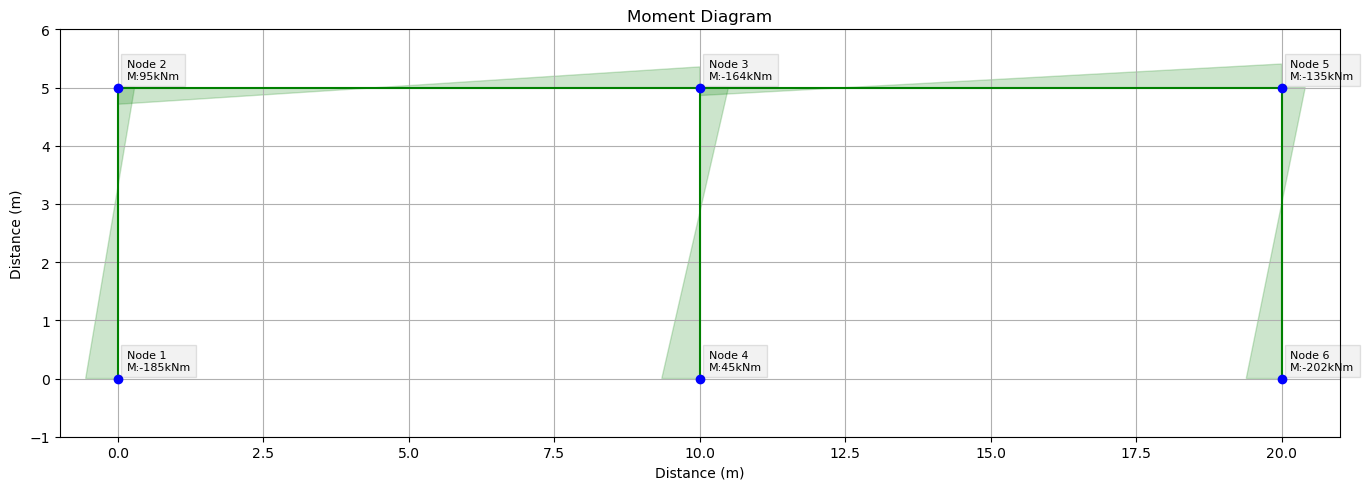

In [8]:
fontSize = 8 
margin = 1
dx = 0.15 #x-offset for node label
dy = 0.15 #y-offset for node label
momentScale = 3*10**-6

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

for n, mbr in enumerate(members):
    node_i = mbr[0] 
    node_j = mbr[1]
    
    ix = nodes[node_i-1,0] #x coordinate of node_i of the member
    iy = nodes[node_i-1,1] #y coordinate of node_j of the member
    jx = nodes[node_j-1,0] #x coordinate of node_j of the member
    jy = nodes[node_j-1,1] #y coordinate of node_j of the member
    
    #note: default numbering in python index are (0,1,2,.....), pag sa integer (1,2,3,......)
    ia = 3*node_i-3 #index 0 
    ib = 3*node_i-1 #index 2
    ja = 3*node_j-3 #index 3
    jb = 3*node_j-1 #index 5

    axes.plot([ix,jx],[iy,jy],'g')
    
    #Plot MBD for each member
    theta = orientations[n]
    length = lengths[n]
    
    mi = mbrMoments[n,0]*momentScale
    mj = mbrMoments[n,1]*momentScale

    #Correct Shape Segment
    if(mi<0 and mj>0):
        mi = abs(mi)
        mj = abs(mj)
    elif(mi<0 and mj<0):
        mi = abs(mi)
        mj = -abs(mj)
    elif(mi>0 and mj>0):
        mi = -abs(mi)
        mj = abs(mj)
    elif(mi>0 and mj<0):
        mi = -abs(mi)
        mj = -abs(mj)
    elif(mi>0 and mj==0):
        mi = -abs(mi)
    elif(mi<0 and mj==0):
        mi = abs(mi)
    
    #rotation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    TM = np.array([[c,-s],[s,c]])

    pt1 = np.array([0,0])
    pt2 = np.array([0,mi])
    pt3 = np.array([length,mj])
    pt4 = np.array([length,0])

    #Rotated Coordinates
    pt1r = np.matmul(TM,pt1)
    pt2r = np.matmul(TM,pt2)
    pt3r = np.matmul(TM,pt3)
    pt4r = np.matmul(TM,pt4)

    #Shift in BMD position
    xShift = ix
    yShift = iy

    #Final Shifted and rotated coordinates
    xr = xShift + np.array([pt1r[0],pt2r[0],pt3r[0],pt4r[0]])
    yr = yShift + np.array([pt1r[1],pt2r[1],pt3r[1],pt4r[1]])

    axes.add_patch(patch.Polygon(xy = list(zip(xr,yr)),facecolor ='green', alpha=0.2))
    axes.add_patch(patch.Polygon(xy = list(zip(xr,yr)),fill =None,edgecolor = 'green', alpha=0.2))


#Plot Nodes
for n, node in enumerate(nodes):
    axes.plot([node[0]],[node[1]],'bo')

    if(n<len(members)):
        mi = round(mbrMoments[n,0]/1000)
        label = "Node " + str(n+1) + "\nM:" + str(mi) + "kNm"
        plt.text(node[0]+dx, node[1]+dy, label,
                 fontsize = fontSize,
                 bbox = dict(facecolor ='grey', alpha = 0.1))

    if(n==len(members-1)):
        mi = round(mbrMoments[n-1,1]/1000)
        label = "Node " + str(n+1) + "\nM:" + str(mi) + "kNm"
        plt.text(node[0]+dx, node[1]+dy, label,
                 fontsize = fontSize,
                 bbox = dict(facecolor ='grey', alpha = 0.1))

#Axis Limits
maxX = nodes.max(0)[0]
maxY = nodes.max(0)[1]
minX = nodes.min(0)[0]
minY = nodes.min(0)[1]
axes.set_xlim([minX-margin, maxX + margin])
axes.set_ylim([minY-margin, maxY + margin])

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Moment Diagram')
axes.grid()
plt.show()


### Shear Force Diagram

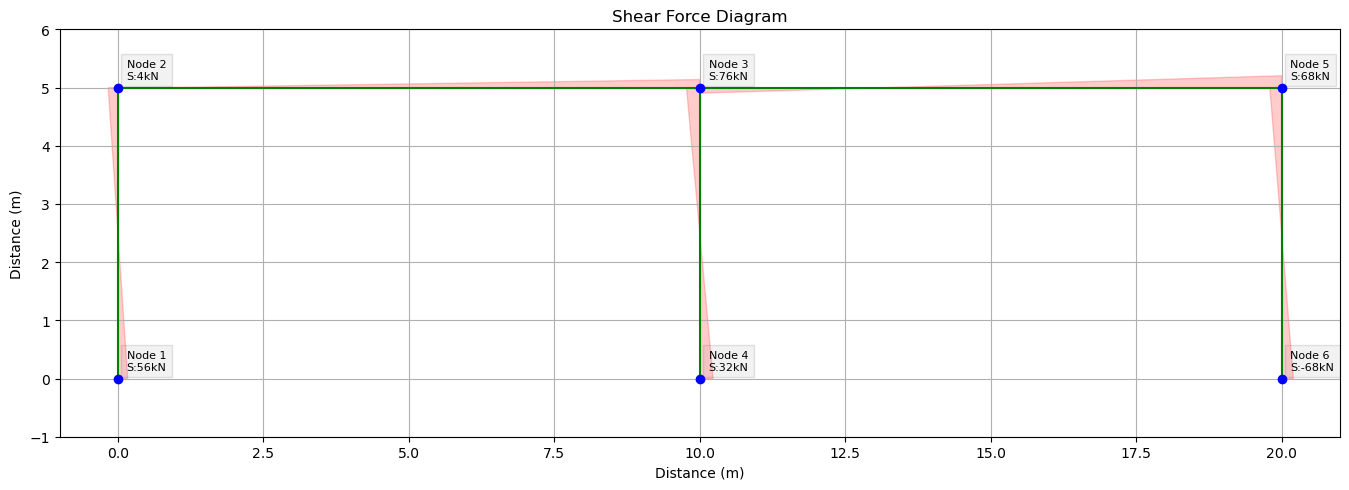

In [9]:
fontSize = 8 
margin = 1
dx = 0.15 #x-offset for node label
dy = 0.15 #y-offset for node label
shearScale = 3*10**-6

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

for n, mbr in enumerate(members):
    node_i = mbr[0] 
    node_j = mbr[1]
    
    ix = nodes[node_i-1,0] #x coordinate of node_i of the member
    iy = nodes[node_i-1,1] #y coordinate of node_j of the member
    jx = nodes[node_j-1,0] #x coordinate of node_j of the member
    jy = nodes[node_j-1,1] #y coordinate of node_j of the member
    
    #note: default numbering in python index are (0,1,2,.....), pag sa integer (1,2,3,......)
    ia = 3*node_i-3 #index 0 
    ib = 3*node_i-1 #index 2
    ja = 3*node_j-3 #index 3
    jb = 3*node_j-1 #index 5

    axes.plot([ix,jx],[iy,jy],'g')
    
    #Plot SFD for each member
    theta = orientations[n]
    length = lengths[n]
    
    si = mbrShears[n,0]*shearScale
    sj = mbrShears[n,1]*shearScale

    #Correct Shape Segment
    if(si<0 and sj>0):
        si = -abs(si)
        sj = -abs(sj)
    elif(mi<0 and mj<0):
        si = -abs(si)
        sj = abs(sj)
    elif(mi>0 and mj>0):
        si = abs(si)
        sj = -abs(sj)
    elif(mi>0 and mj<0):
        si = abs(si)
        sj = abs(sj)
    elif(si>0 and sj==0):
        si = abs(si)
    elif(mi<0 and sj==0):
        si = -abs(si)
    
    #rotation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    TM = np.array([[c,-s],[s,c]])

    pt1 = np.array([0,0])
    pt2 = np.array([0,si])
    pt3 = np.array([length,sj])
    pt4 = np.array([length,0])

    #Rotated Coordinates
    pt1r = np.matmul(TM,pt1)
    pt2r = np.matmul(TM,pt2)
    pt3r = np.matmul(TM,pt3)
    pt4r = np.matmul(TM,pt4)

    #Shift in BMD position
    xShift = ix
    yShift = iy

    #Final Shifted and rotated coordinates
    xr = xShift + np.array([pt1r[0],pt2r[0],pt3r[0],pt4r[0]])
    yr = yShift + np.array([pt1r[1],pt2r[1],pt3r[1],pt4r[1]])

    axes.add_patch(patch.Polygon(xy = list(zip(xr,yr)),facecolor ='red', alpha=0.2))
    axes.add_patch(patch.Polygon(xy = list(zip(xr,yr)),fill =None,edgecolor = 'red', alpha=0.2))


#Plot Nodes
for n, node in enumerate(nodes):
    axes.plot([node[0]],[node[1]],'bo')

    if(n<len(members)):
        si = round(mbrShears[n,0]/1000)
        label = "Node " + str(n+1) + "\nS:" + str(si) + "kN"
        plt.text(node[0]+dx, node[1]+dy, label,
                 fontsize = fontSize,
                 bbox = dict(facecolor ='grey', alpha = 0.1))

    if(n==len(members-1)):
        si = round(mbrShears[n-1,1]/1000)
        label = "Node " + str(n+1) + "\nS:" + str(si) + "kN"
        plt.text(node[0]+dx, node[1]+dy, label,
                 fontsize = fontSize,
                 bbox = dict(facecolor ='grey', alpha = 0.1))

#Axis Limits
maxX = nodes.max(0)[0]
maxY = nodes.max(0)[1]
minX = nodes.min(0)[0]
minY = nodes.min(0)[1]
axes.set_xlim([minX-margin, maxX + margin])
axes.set_ylim([minY-margin, maxY + margin])

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Shear Force Diagram')
axes.grid()
plt.show()


### Summary

In [10]:
print('REACTIONS')
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]
    print('-Reaction at DoF {one}:{two} kN'.format(one=index+1,two=round(FG[index].item()/1000,2)))

print("")
print("MEMBER AXIAL FORCES")
for n,mbr in enumerate(members):
    print('- Force in member {one} (nodes {two} to {three} is {four} kN)'.format(one=n+1, two=mbr[0], three = mbr[1], four=round(mbrForces[n]/1000,2)))

print("")
print("MEMBER SHEAR FORCES")
for n,mbr in enumerate(members):
    print('- Shear force in member {one} (nodes {two}/{three} to {four}/{five} kN)'.format(one=n+1, two=mbr[0], three = mbr[1], four=round(mbrShears[n,0]/1000,2), five=round(mbrShears[n,1]/1000,2)))

print("")
print("MEMBER MOMENTS")
for n,mbr in enumerate(members):
    print('- Moments in member {one} (nodes {two}/{three} to {four}/{five} kN)'.format(one=n+1, two=mbr[0], three = mbr[1], four=round(mbrMoments[n,0]/1000,2), five=round(mbrMoments[n,1]/1000,2)))

print("")
print("NODAL DISPLACEMENTS")
for n, node in enumerate(nodes):
    ix = 3*(n+1)-3
    iy = ix+1
    iz = ix+2
    ux = round(UG[ix,0],5)
    uy = round(UG[iy,0],5)
    theta = round(UG[iz,0],5)
    print('- Node {one}:Ux= {two} m, Uy = {three} m, theta = {four} radians'. format(one=n+1,two=ux,three=uy,four=theta))

REACTIONS
-Reaction at DoF 1:-56.05 kN
-Reaction at DoF 2:3.58 kN
-Reaction at DoF 3:-184.93 kN
-Reaction at DoF 10:-76.37 kN
-Reaction at DoF 11:78.34 kN
-Reaction at DoF 12:-217.66 kN
-Reaction at DoF 16:-67.58 kN
-Reaction at DoF 17:68.08 kN
-Reaction at DoF 18:-202.47 kN

MEMBER AXIAL FORCES
- Force in member 1 (nodes 1 to 2 is -3.58 kN)
- Force in member 2 (nodes 2 to 3 is -143.95 kN)
- Force in member 3 (nodes 3 to 4 is -78.34 kN)
- Force in member 4 (nodes 3 to 5 is -67.58 kN)
- Force in member 5 (nodes 5 to 6 is -68.08 kN)

MEMBER SHEAR FORCES
- Shear force in member 1 (nodes 1/2 to 56.05/-56.05 kN)
- Shear force in member 2 (nodes 2/3 to 3.58/46.42 kN)
- Shear force in member 3 (nodes 3/4 to 76.37/-76.37 kN)
- Shear force in member 4 (nodes 3/5 to 31.92/68.08 kN)
- Shear force in member 5 (nodes 5/6 to 67.58/-67.58 kN)

MEMBER MOMENTS
- Moments in member 1 (nodes 1/2 to -184.93/-95.3 kN)
- Moments in member 2 (nodes 2/3 to 95.3/118.88 kN)
- Moments in member 3 (nodes 3/4 to -1

In [ ]:
def print_reactions(restrained_dofs, K_global, force_vector, displacements):
    print("REACTIONS")
    for i in restrained_dofs:
        reaction = np.dot(K_global[i, :], displacements) - force_vector[i]
        print(f"- Reaction at DoF {i + 1}: {reaction / 1000:.2f} kN")

def print_member_forces(elements, member_forces):
    print("MEMBER AXIAL FORCES")
    for idx, element in enumerate(elements):
        start, end = element
        print(f"- Force in member {idx + 1} (nodes {start + 1} to {end + 1}): {member_forces[idx] / 1000:.2f} kN")

def print_member_shears(elements, member_shears):
    print("MEMBER SHEAR FORCES")
    for idx, element in enumerate(elements):
        start, end = element
        print(f"- Shear in member {idx + 1} (nodes {start + 1} to {end + 1}): {member_shears[idx] / 1000:.2f} kN")

def print_member_moments(elements, member_moments):
    print("MEMBER MOMENTS")
    for idx, element in enumerate(elements):
        start, end = element
        print(f"- Moment in member {idx + 1} (nodes {start + 1} to {end + 1}): {member_moments[idx] / 1000:.2f} kNm")

def print_nodal_displacements(nodes, displacements):
    print("NODAL DISPLACEMENTS")
    for i, node in enumerate(nodes):
        ux, uy, uz = displacements[i * 3:(i + 1) * 3]
        print(f"- Node {i + 1}: Ux = {ux:.5f} m, Uy = {uy:.5f} m, Uz = {uz:.5f} m")